<a href="https://colab.research.google.com/github/00Nithin00/Bone_Fracture_detection/blob/main/Bone_Fracture_Detection_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and Config

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm

In [ ]:
%%writefile kaggle.json
{"username":"sairamparshi07","key":"a07ce4e9f16b95b9b0c358f5b12deec7"}

Writing kaggle.json


In [ ]:
import os

# Function to download Kaggle dataset
def download_kaggle_dataset(dataset_path):
    # Ensure Kaggle API is installed
    os.system('pip install -q kaggle')

    # Check for kaggle.json file
    if not os.path.isfile('kaggle.json'):
        print("kaggle.json file not found. Please upload it.")
        return

    # Set up Kaggle directory and permissions
    os.system('mkdir -p ~/.kaggle')
    os.system('cp kaggle.json ~/.kaggle/')
    os.system('chmod 600 ~/.kaggle/kaggle.json')

    # Download and unzip the dataset
    os.system(f'kaggle datasets download -d {dataset_path}')
    zip_file = f'{dataset_path.split("/")[-1]}.zip'
    os.system(f'unzip -q {zip_file}')

# Example usage
download_kaggle_dataset('ahmedashrafahmed/bone-fracture')


# Data Loading


In [ ]:
import pandas as pd

# Function to load data from a given dataset path
def load_data(dataset_path):
    images, labels = [], []
    for subfolder in os.listdir(dataset_path):
        subfolder_path = os.path.join(dataset_path, subfolder)
        if not os.path.isdir(subfolder_path):
            continue
        for image_filename in os.listdir(subfolder_path):
            if image_filename.endswith(".jpg"):
                image_path = os.path.join(subfolder_path, image_filename)
                images.append(image_path)
                labels.append(subfolder)
    return pd.DataFrame({'image': images, 'label': labels})

# Load train, test, and validation data
train_data = load_data('/content/dataset/train')
test_data = load_data('/content/dataset/test')
val_data = load_data('/content/dataset/val')


# Visualization of Dataset


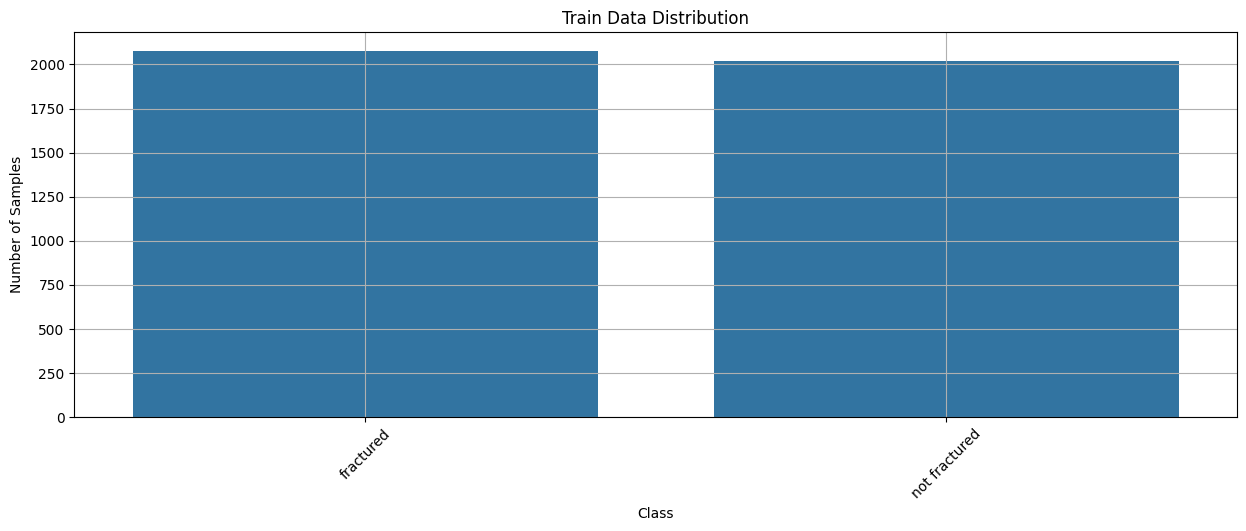

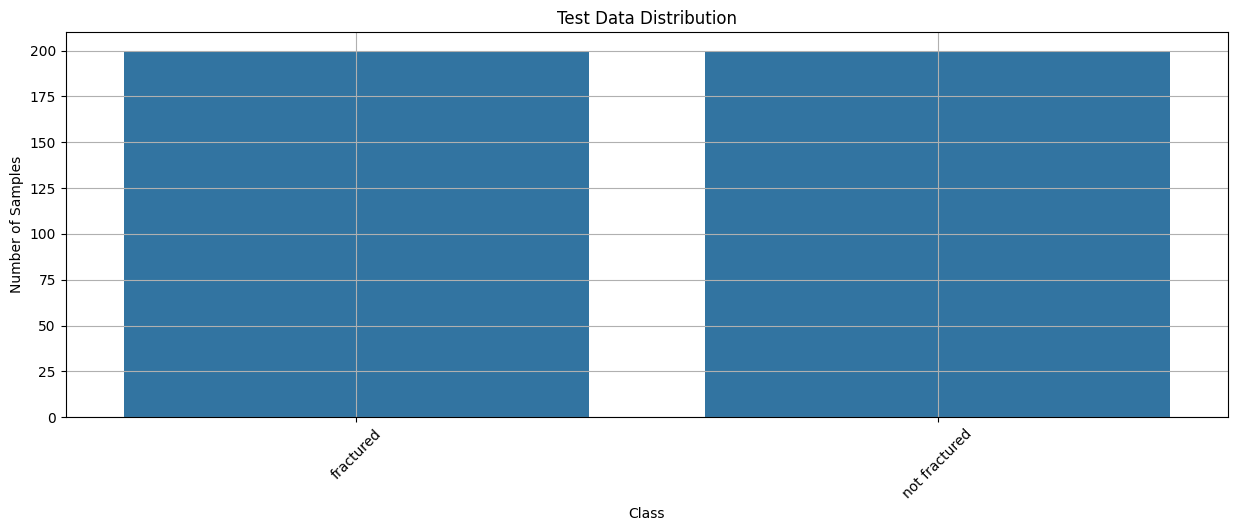

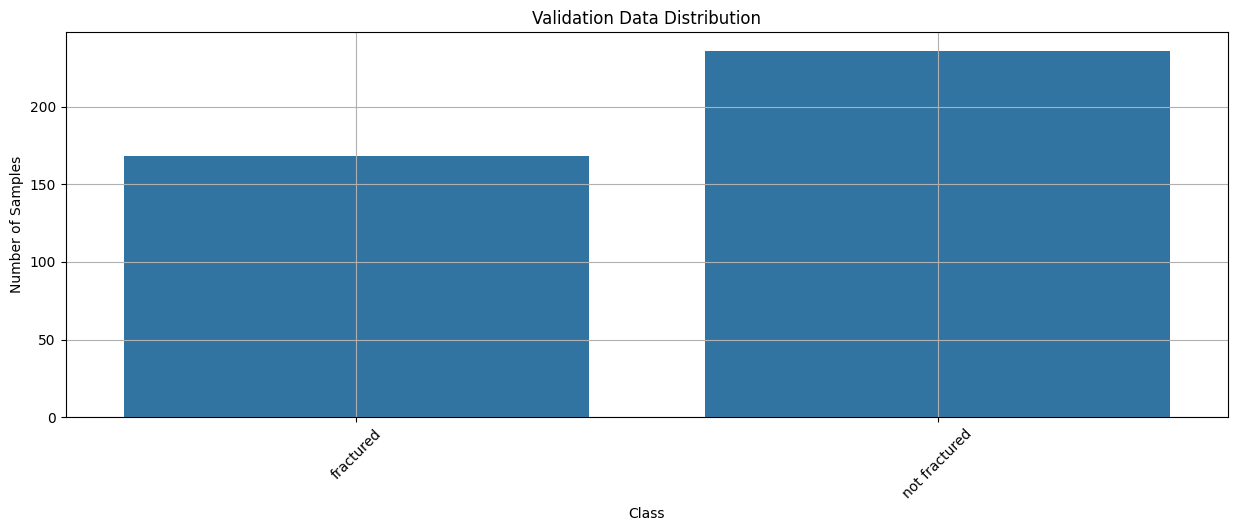

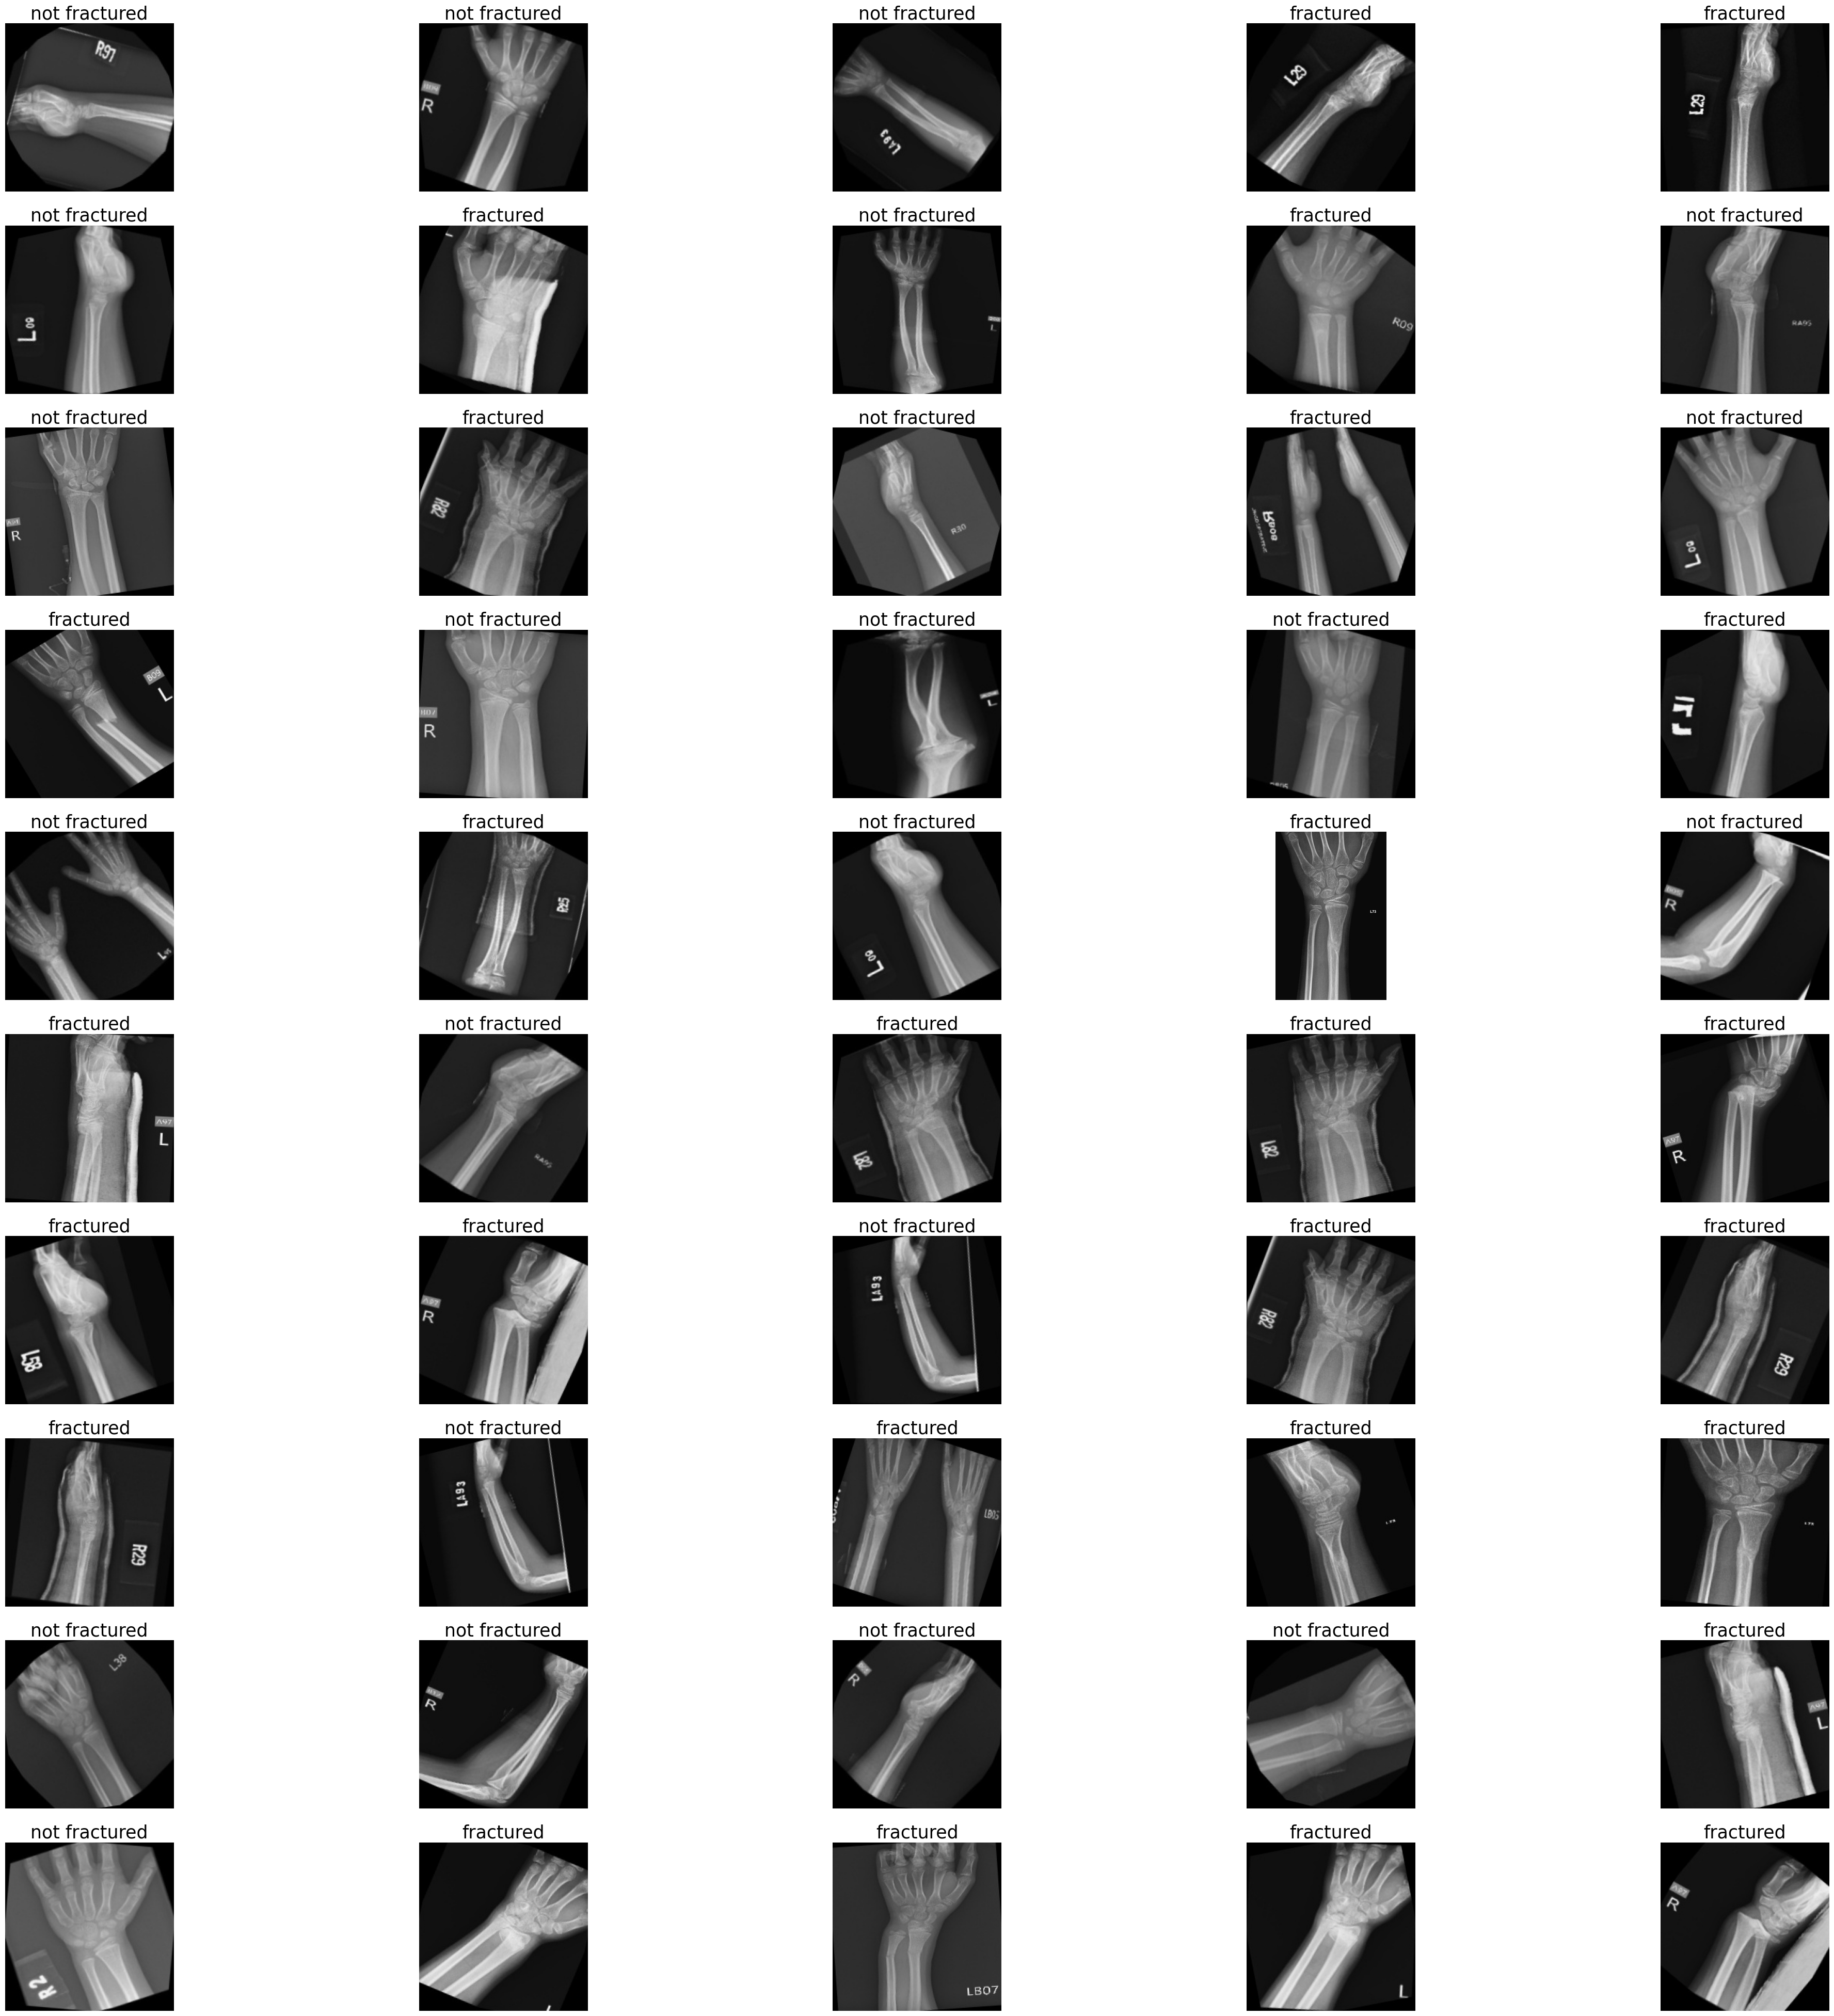

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import numpy as np

# Function to plot data distribution
def plot_data_distribution(data, title):
    plt.figure(figsize=(15, 5))
    sns.countplot(x=data['label'])
    plt.xlabel("Class")
    plt.ylabel("Number of Samples")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.grid(True)

# Plotting the distribution for train, test, and validation sets
plot_data_distribution(train_data, 'Train Data Distribution')
plot_data_distribution(test_data, 'Test Data Distribution')
plot_data_distribution(val_data, 'Validation Data Distribution')

# Function to display sample images
def display_sample_images(data, num_samples=10):
    plt.figure(figsize=(50, 50))
    for i, idx in enumerate(np.random.randint(0, len(data), num_samples)):
        plt.subplot(10, 5, i + 1)
        img = cv2.imread(data.iloc[idx]['image'])
        plt.imshow(img)
        plt.axis('off')
        plt.title(data.iloc[idx]['label'], fontsize=25)

# Display sample images from training set
display_sample_images(train_data, 50)


# Data Augmentation


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Image data generation/augmentation
image_size = (224, 224)
batch_size = 32
datagen = ImageDataGenerator(rescale=1./255)

# Creating generators for train, test, and validation sets
train_generator = datagen.flow_from_dataframe(
    train_data, x_col='image', y_col='label', target_size=image_size,
    batch_size=batch_size, class_mode='binary', shuffle=True
)
test_generator = datagen.flow_from_dataframe(
    test_data, x_col='image', y_col='label', target_size=image_size,
    batch_size=batch_size, class_mode='binary', shuffle=False
)
val_generator = datagen.flow_from_dataframe(
    val_data, x_col='image', y_col='label', target_size=image_size,
    batch_size=batch_size, class_mode='binary', shuffle=True
)


Found 4097 validated image filenames belonging to 2 classes.
Found 399 validated image filenames belonging to 2 classes.
Found 404 validated image filenames belonging to 2 classes.


# Modeling

In [ ]:
class_num=1
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3),activation=tf.nn.relu,input_shape=(224,224,3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2,2)))
model.add(keras.layers.Conv2D(filters=64, kernel_size=(3,3),activation=tf.nn.relu))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2,2)))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Conv2D(filters=128, kernel_size=(3,3),activation=tf.nn.relu))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2,2)))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256,activation=tf.nn.relu))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Dense(128,activation=tf.nn.relu))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Dense(class_num,activation=tf.nn.sigmoid))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_3 (Bat  (None, 222, 222, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_4 (Bat  (None, 109, 109, 64)      256       
 chNormalization)                                                
                                                      

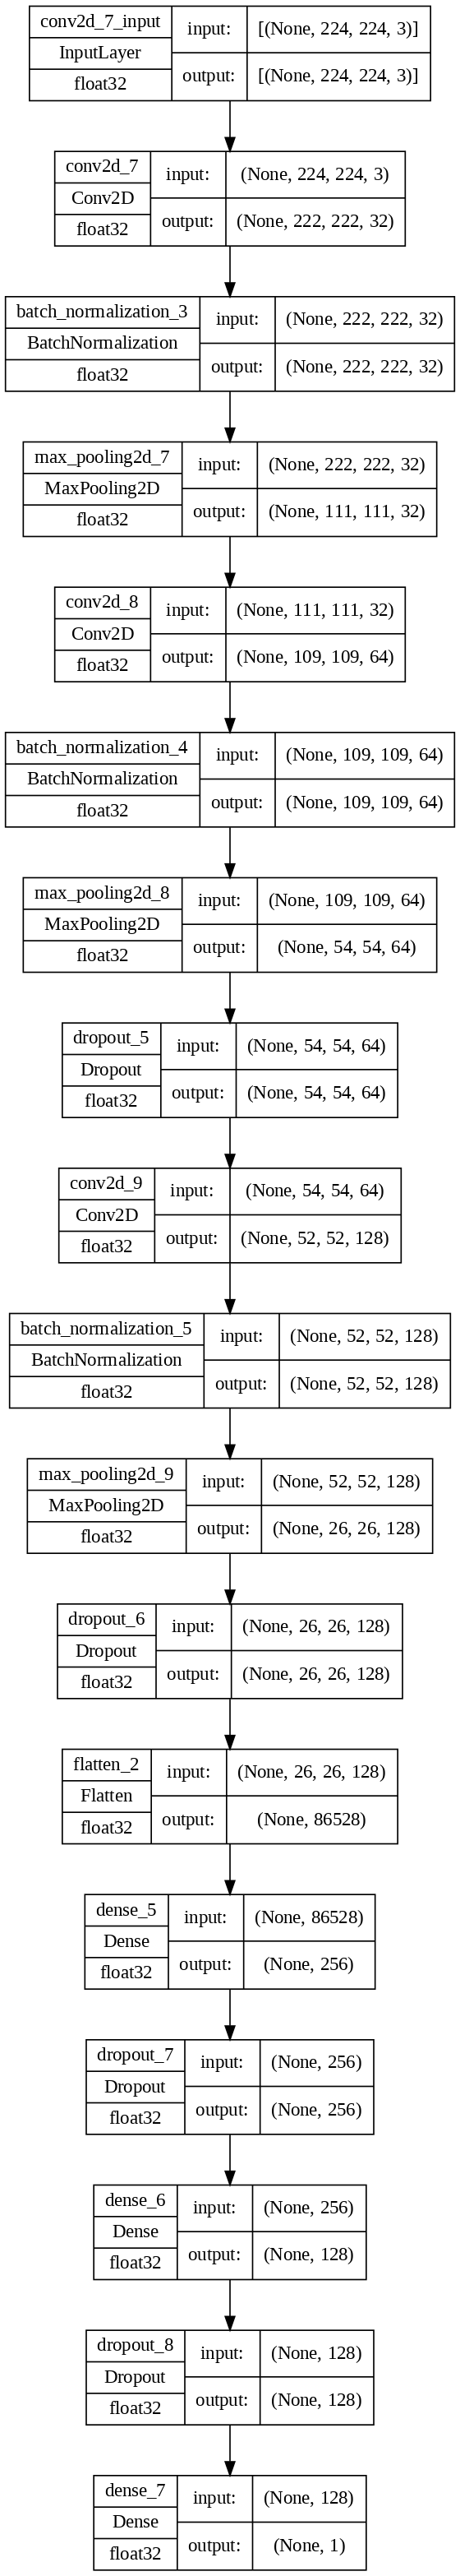

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [ ]:
checkpoint_cb =ModelCheckpoint("my_keras_model.h5", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=5, restore_best_weights=True)
model.compile(optimizer ='adam', loss='binary_crossentropy', metrics=['accuracy',keras.metrics.SpecificityAtSensitivity(0.5),keras.metrics.AUC()])
hist=model.fit_generator(train_generator,epochs=10,validation_data=val_generator,callbacks=[checkpoint_cb,early_stopping_cb])

<ipython-input-29-62f75649d520>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist=model.fit_generator(train_generator,epochs=10,validation_data=val_generator,callbacks=[checkpoint_cb,early_stopping_cb])


Epoch 1/10
129/129 [==============================] - ETA: 0s - loss: 2.9835 - accuracy: 0.7432 - specificity_at_sensitivity_1: 0.8417 - auc_1: 0.7822

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


129/129 [==============================] - 18s 95ms/step - loss: 2.9835 - accuracy: 0.7432 - specificity_at_sensitivity_1: 0.8417 - auc_1: 0.7822 - val_loss: 19.8541 - val_accuracy: 0.5842 - val_specificity_at_sensitivity_1: 0.0000e+00 - val_auc_1: 0.5000
Epoch 2/10
129/129 [==============================] - 12s 94ms/step - loss: 0.9764 - accuracy: 0.8518 - specificity_at_sensitivity_1: 0.9423 - auc_1: 0.9062 - val_loss: 12.3451 - val_accuracy: 0.5842 - val_specificity_at_sensitivity_1: 0.0000e+00 - val_auc_1: 0.5000
Epoch 3/10
129/129 [==============================] - 11s 86ms/step - loss: 0.4059 - accuracy: 0.9190 - specificity_at_sensitivity_1: 0.9692 - auc_1: 0.9590 - val_loss: 4.7460 - val_accuracy: 0.6114 - val_specificity_at_sensitivity_1: 0.1726 - val_auc_1: 0.5801
Epoch 4/10
129/129 [==============================] - 12s 92ms/step - loss: 0.2562 - accuracy: 0.9402 - specificity_at_sensitivity_1: 0.9880 - auc_1: 0.9781 - val_loss: 1.6635 - val_accuracy: 0.7723 - val_specificit

In [ ]:
hist_=pd.DataFrame(history.history)
hist_

loss  accuracy  specificity_at_sensitivity       auc   val_loss  \
0  3.616755  0.724921                    0.821463  0.766576  22.047369   
1  0.845531  0.865267                    0.949952  0.919102  13.399078   
2  0.455430  0.903832                    0.973532  0.955804   6.155796   
3  0.335553  0.927752                    0.984601  0.971034   0.544004   
4  0.228689  0.934098                    0.990375  0.979109   0.148531   
5  0.163920  0.956309                    0.990857  0.986656   0.053871   
6  0.103800  0.969978                    0.995669  0.992711   0.016854   
7  0.113678  0.966073                    0.996150  0.992422   0.027444   
8  0.113922  0.972419                    0.994706  0.992036   0.112278   
9  0.143280  0.968758                    0.991819  0.989606   0.915044   

   val_accuracy  val_specificity_at_sensitivity   val_auc  
0      0.584158                        0.000000  0.500000  
1      0.584158                        0.000000  0.500000  
2      0.618812                        0.220238  0.606247  
3      0.913366                        0.898810  0.944751  
4      0.962871                        0.970238  0.983555  
5      0.982673                        1.000000  0.997427  
6      0.997525                        1.000000  0.999886  
7      0.982673                        1.000000  0.999672  
8      0.982673                        0.988095  0.993316  
9      0.881188                        1.000000  0.939707

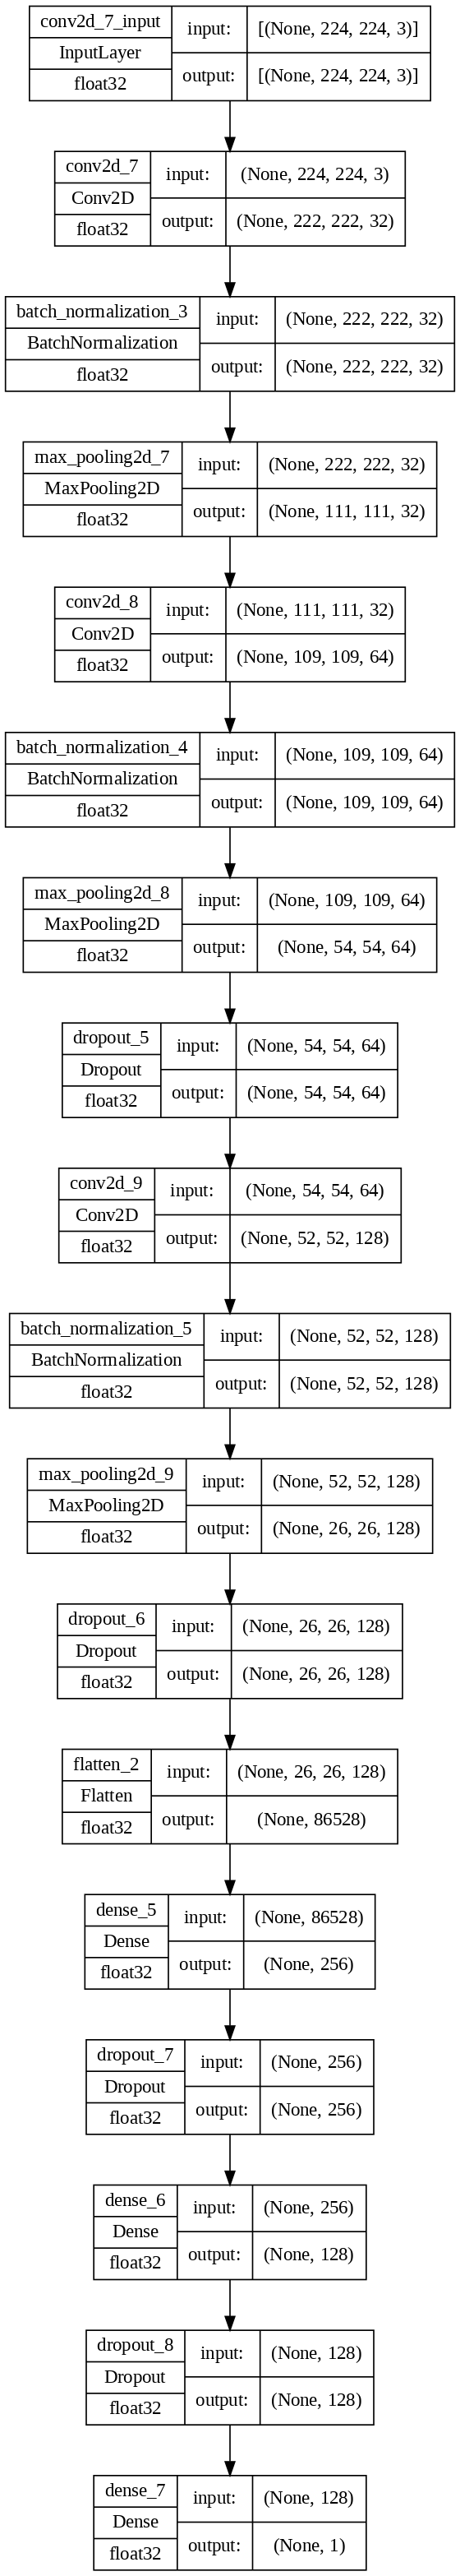

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

# Evaluation and Visualization of Model Performance


In [ ]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Plotting Training History
def plot_training_history(hist):
    plt.figure(figsize=(15, 10))

    # Subplot for Loss
    plt.subplot(2, 2, 1)
    plt.plot(hist['loss'], 'b-o', label='Train Loss')
    plt.plot(hist['val_loss'], 'r-o', label='Validation Loss')
    plt.title('Train & Validation Loss', fontsize=20)
    plt.legend()

    # Subplot for Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(hist['accuracy'], 'b-o', label='Train Accuracy')
    plt.plot(hist['val_accuracy'], 'r-o', label='Validation Accuracy')
    plt.title('Train & Validation Accuracy', fontsize=20)
    plt.legend()

    # Subplot for Sensitivity
    plt.subplot(2, 2, 3)
    plt.plot(hist['specificity_at_sensitivity'], 'b-o', label='Train Specificity at Sensitivity')
    plt.plot(hist['val_specificity_at_sensitivity'], 'r-o', label='Validation Specificity at Sensitivity')
    plt.title('Train & Validation Sensitivity', fontsize=20)
    plt.legend()

    # Subplot for AUC
    plt.subplot(2, 2, 4)
    plt.plot(hist['auc'], 'b-o', label='Train AUC')
    plt.plot(hist['val_auc'], 'r-o', label='Validation AUC')
    plt.title('Train & Validation AUC', fontsize=20)
    plt.legend()

    plt.show()

# Evaluating Model Performance
def evaluate_model(model, test_generator):
    score, acc, sensitivity, auc = model.evaluate(test_generator)
    print('Test Loss =', score)
    print('Test Accuracy =', acc)
    print('Test Sensitivity =', sensitivity)
    print('Test AUC =', auc)

# Generating Confusion Matrix and Classification Report
def generate_reports(y_test, y_pred):
    # Confusion Matrix
    CM = confusion_matrix(y_test, y_pred)
    sns.heatmap(CM, fmt='g', center=True, cbar=False, annot=True, cmap='Blues')
    plt.show()

    # Classification Report
    ClassificationReport = classification_report(y_test, y_pred)
    print('Classification Report is : ', ClassificationReport)

# Displaying Predictions on Test Images
def display_test_predictions(test_generator, model, y_test):
    class_names = ['Fractured', 'Not Fractured']
    batch = next(test_generator)
    images = batch[0]

    plt.figure(figsize=(50, 50))
    for n in range(32):
        plt.subplot(8, 4, n + 1)
        plt.imshow(images[n])
        plt.axis('off')
        plt.title(class_names[int(y_test[n])], fontsize=25)

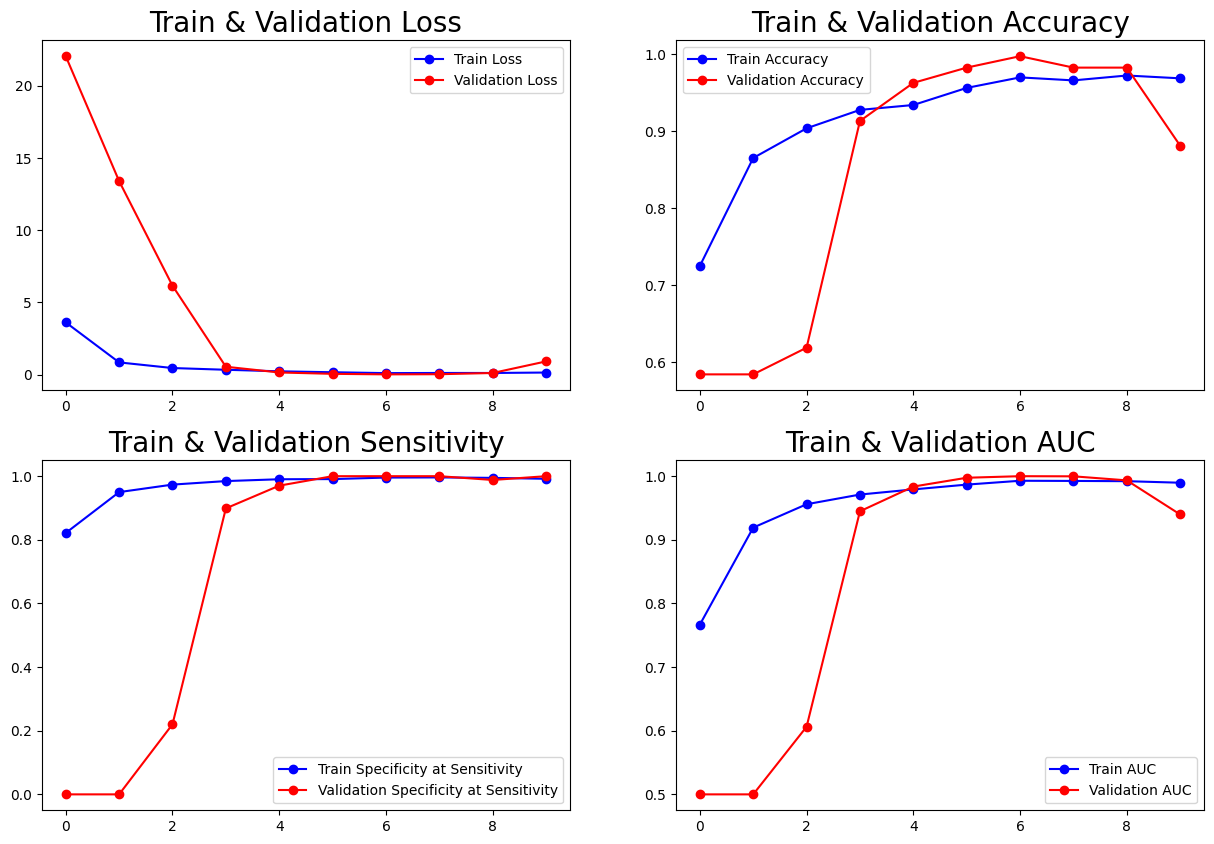

13/13 [==============================] - 1s 96ms/step - loss: 0.0670 - accuracy: 0.9875 - specificity_at_sensitivity_1: 1.0000 - auc_1: 0.9971
Test Loss = 0.06701675802469254
Test Accuracy = 0.9874686598777771
Test Sensitivity = 1.0
Test AUC = 0.9971356391906738


In [ ]:
plot_training_history(hist_)

# Assuming test_generator, model, y_test, and y_pred are defined
evaluate_model(model, test_generator)


In [ ]:
y_test =test_generator.classes
predictions = model.predict(test_generator)
y_pred = np.where(predictions >= 0.5, 1, 0)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})
df

13/13 [==============================] - 1s 66ms/step


Actual  Prediction
0         0           0
1         0           0
2         0           0
3         0           0
4         0           0
..      ...         ...
394       1           1
395       1           1
396       1           1
397       1           1
398       1           1

[399 rows x 2 columns]

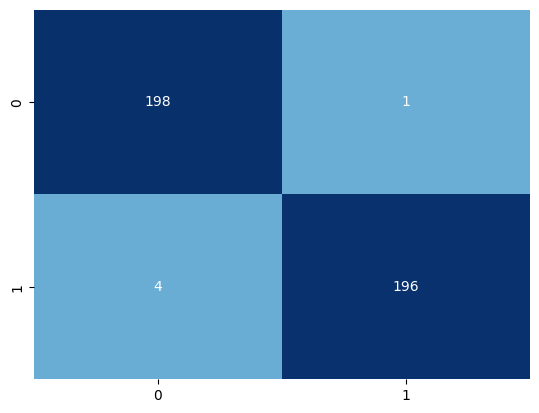

Classification Report is :                precision    recall  f1-score   support

           0       0.98      0.99      0.99       199
           1       0.99      0.98      0.99       200

    accuracy                           0.99       399
   macro avg       0.99      0.99      0.99       399
weighted avg       0.99      0.99      0.99       399



In [ ]:
generate_reports(y_test, y_pred)


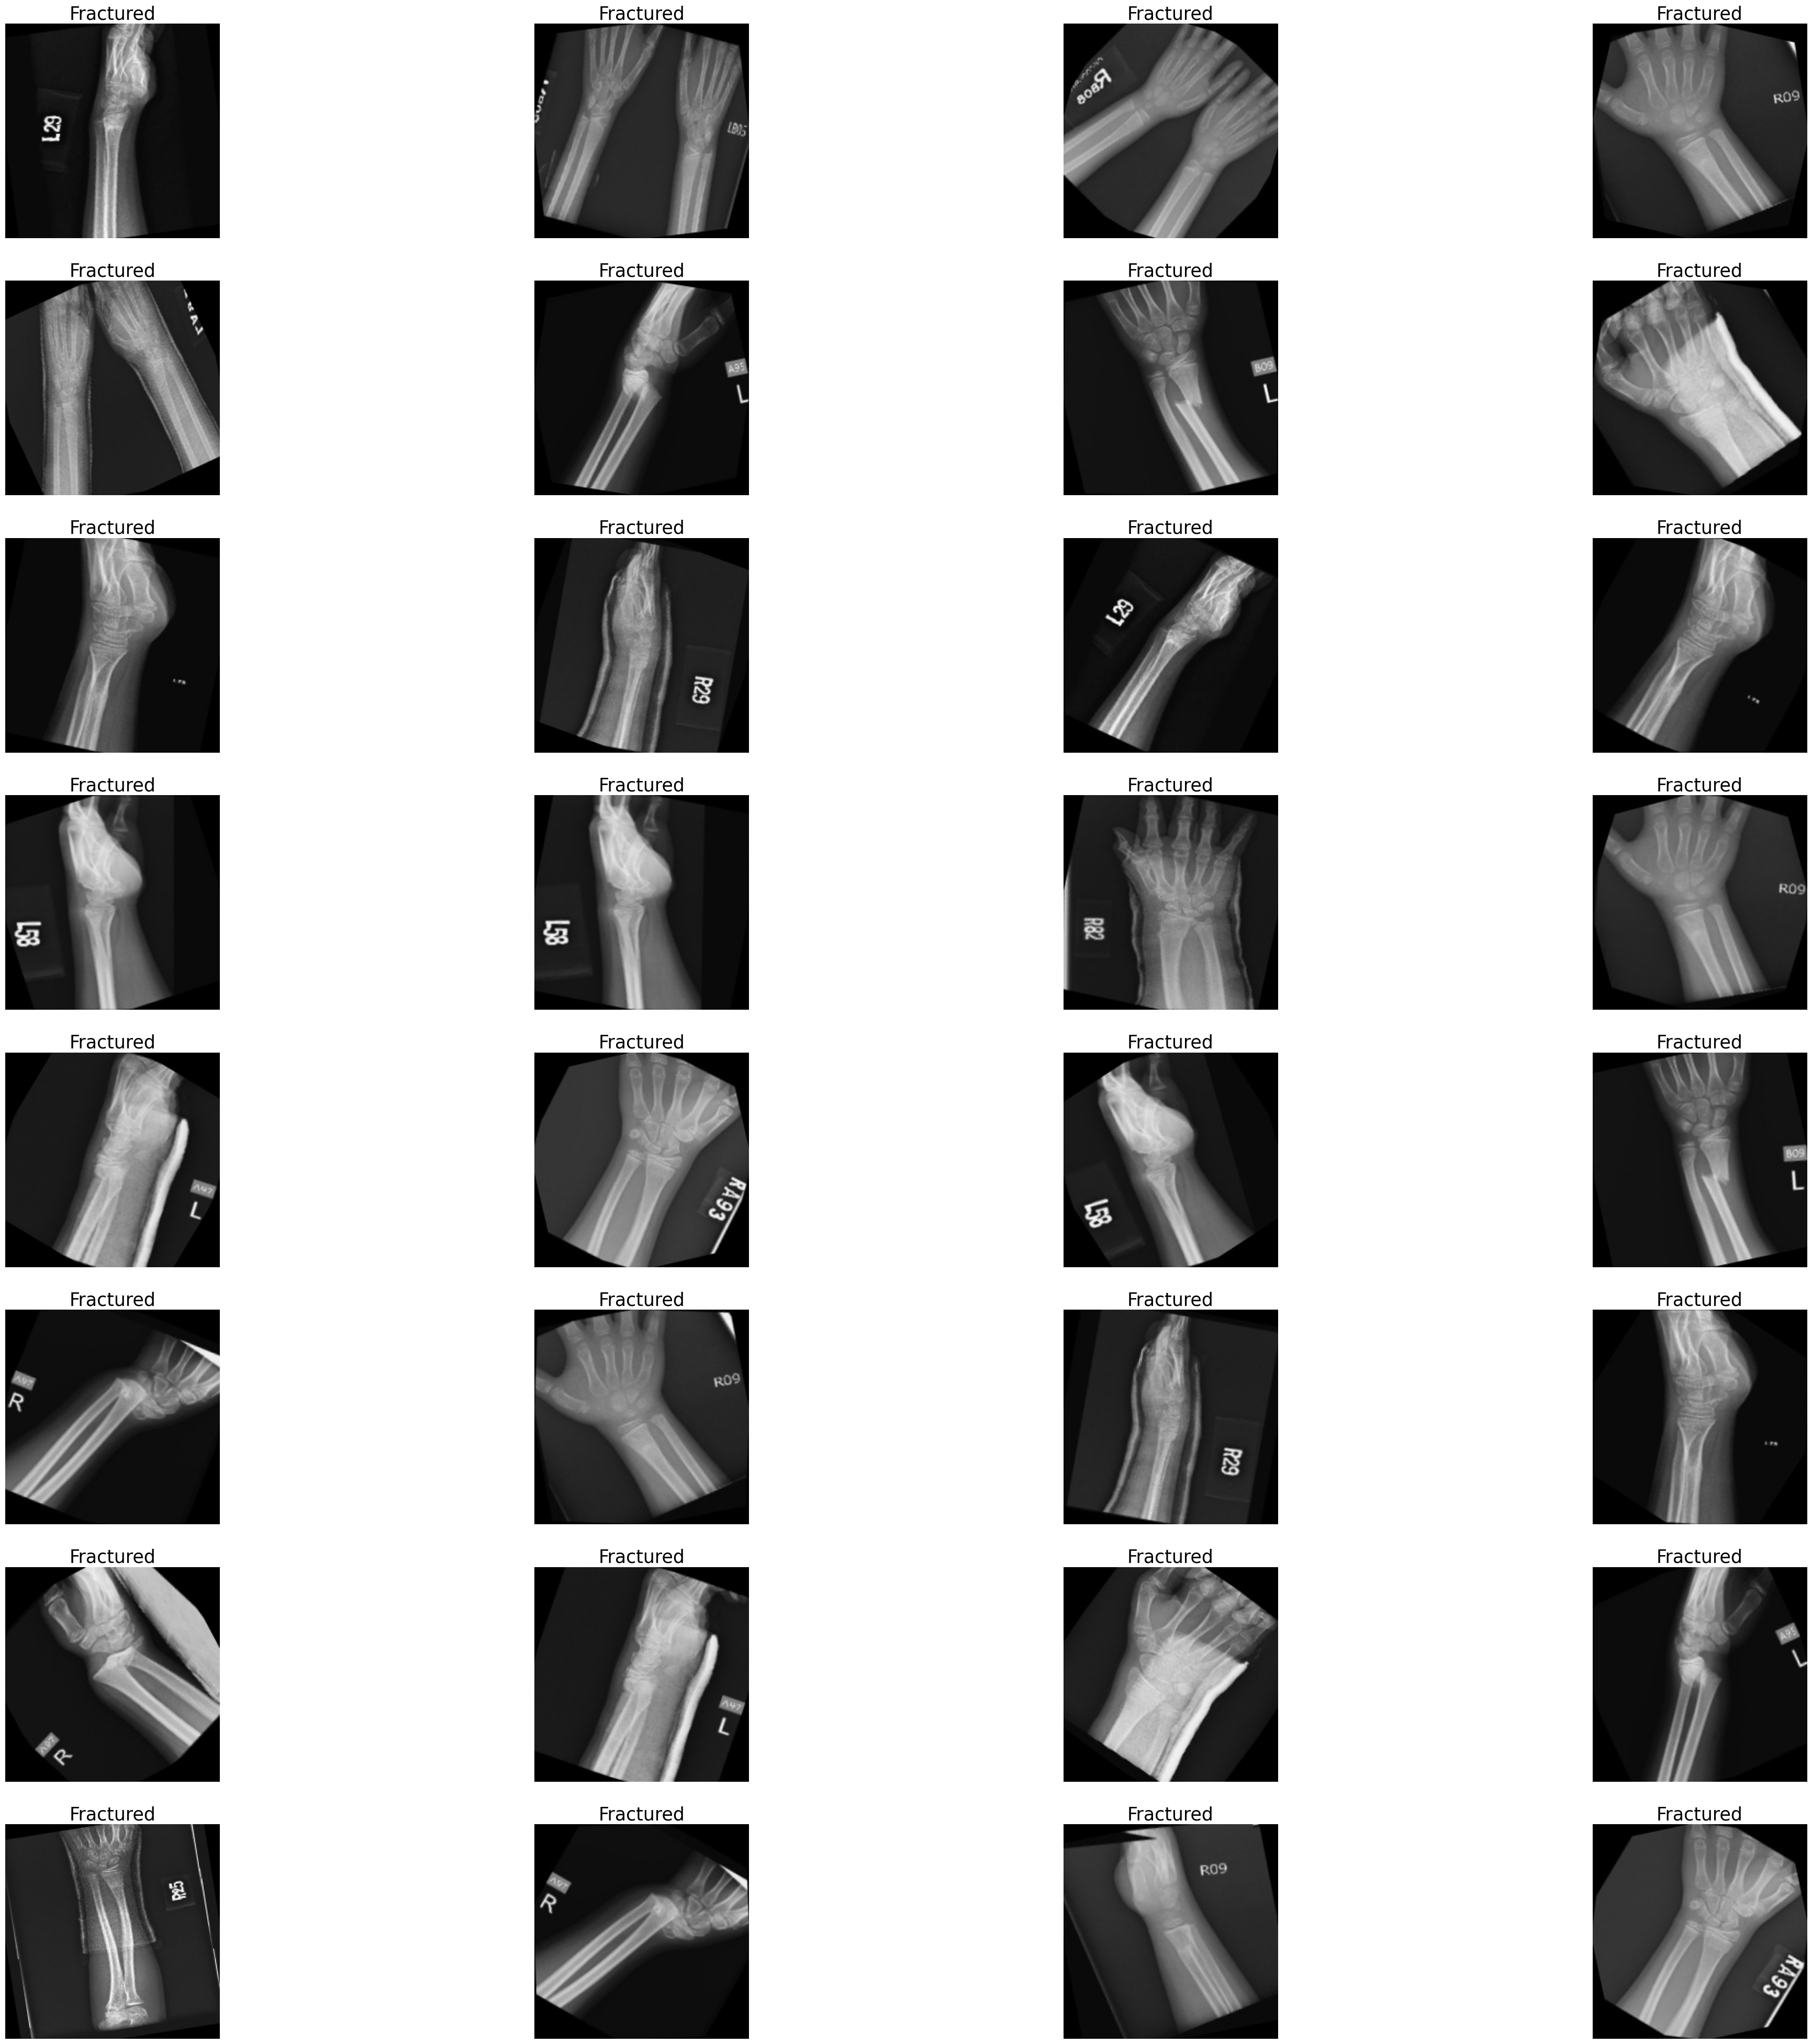

In [ ]:
display_test_predictions(test_generator, model, y_test)

# Usage

In [ ]:
from keras.preprocessing import image
from IPython.display import display
import PIL.Image as PilImage
import numpy as np

def load_and_predict_image(model, image_path=None):
    """
    Loads an image from the given path (or using file upload if no path is provided),
    preprocesses it, and uses the model to predict whether the image shows a bone fracture.

    Args:
    model: The trained keras model.
    image_path: Path to the image file (optional).

    Returns:
    Prediction and probability.
    """
    if image_path is None:
        from google.colab import files
        uploaded = files.upload()
        image_path = list(uploaded.keys())[0]

    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Create a batch
    img_array /= 255.0  # Rescale the image

    # Predict
    predictions = model.predict(img_array)
    predicted_class = 'Not Fractured' if predictions[0][0] >= 0.5 else 'Fractured'
    probability = predictions[0][0] if predictions[0][0] >= 0.5 else 1 - predictions[0][0]

    # Display the image
    display(PilImage.open(image_path))
    print(f"Prediction: {predicted_class}")
    print(f"Probability: {probability:.2f}")


Random Image Path: /content/dataset/val/fractured/89-rotated3-rotated1-rotated1.jpg from fractured directory


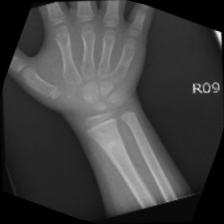

In [ ]:
import os
import random
from IPython.display import Image

def get_random_image_from_subdirectories(parent_directory):
    """
    Selects a random image from a randomly chosen subdirectory within the parent directory.

    Args:
    parent_directory: The path to the parent directory containing subdirectories.

    Returns:
    The path to the randomly selected image, and the subdirectory name.
    """
    if not os.path.isdir(parent_directory):
        print("Parent directory does not exist.")
        return None, None

    subdirectories = [d for d in os.listdir(parent_directory) if os.path.isdir(os.path.join(parent_directory, d))]
    if not subdirectories:
        print("No subdirectories found.")
        return None, None

    selected_subdir = random.choice(subdirectories)
    subdir_path = os.path.join(parent_directory, selected_subdir)

    images = [img for img in os.listdir(subdir_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if not images:
        print(f"No images found in {selected_subdir} directory.")
        return None, None

    random_image = random.choice(images)
    image_path = os.path.join(subdir_path, random_image)

    return image_path, selected_subdir

# Example usage
parent_directory = '/content/dataset/val'
random_image_path, subdirectory = get_random_image_from_subdirectories(parent_directory)
if random_image_path:
    print(f"Random Image Path: {random_image_path} from {subdirectory} directory")
    display(Image(filename=random_image_path))


1/1 [==============================] - 0s 23ms/step


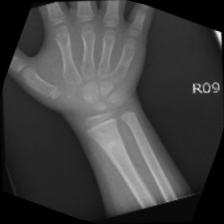

Prediction: Fractured
Probability: 1.00


In [ ]:
load_and_predict_image(model, random_image_path)  # Use this if you have an image path